# *Importing Necessary Libraries*

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor

# *Loading the Data*

In [45]:
housing = pd.read_csv("/content/California_housing_data.csv")

# *Preparing Training & Testing Data*

In [46]:
# Creating bins form income category
housing["income_cat"] = pd.cut(housing["median_income"],bins=[0,1.5,3.0,4.5,6.0,np.inf],labels=[1,2,3,4,5])

# Creating Stratified shuffled set
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=7)
for train_index,test_index in split.split(housing,housing["income_cat"]):
  strat_train_set = housing.iloc[train_index].drop("income_cat",axis=1)
  strat_test_set = housing.loc[test_index].drop("income_cat",axis=1)

housing = strat_train_set.copy()

# Separating labels and features
housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value",axis=1)

# *Creating pipelines*

In [47]:
# Creating Numerical transformation pipeline
num_attri = housing.drop("ocean_proximity",axis=1).columns.tolist()

num_pipeline = Pipeline([
    ("impute",SimpleImputer(strategy="median")),
    ("scaling",StandardScaler()),
])

In [48]:
# Creating Categorical transformation pipeline
cat_attri = ["ocean_proximity"]

cat_pipeline = Pipeline([
    ("encoder",OneHotEncoder(handle_unknown="ignore"))
])
# Use case of handle_unknown - if a new type of catvar(ocean proximity in this case) comes in the data then it will cosider the value of the variable 0

In [49]:
# Creating full pipeline
full_pipeline = ColumnTransformer([
    ("num",num_pipeline,num_attri),
    ("cat",cat_pipeline,cat_attri),
])

In [50]:
# Transforming Training Data
housing_prepared = full_pipeline.fit_transform(housing)

print(housing.shape)

(16512, 9)


In [51]:
# Creating the dataframe after Transformation

df = pd.DataFrame(housing_prepared,columns=num_attri+['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],index=housing.index)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
8088,0.681390,-0.851695,0.422099,-0.422593,-0.331879,0.023297,-0.334438,-0.539136,0.0,0.0,0.0,0.0,1.0
15259,1.151279,-1.221935,-0.294522,-0.390923,-0.542606,-0.287148,-0.496586,0.060388,0.0,0.0,0.0,0.0,1.0
710,-1.253155,0.957327,-0.214898,-0.679683,-0.399699,-1.077121,-0.959108,-0.762457,0.0,0.0,0.0,1.0,0.0
12828,-0.938229,1.435359,-0.374147,-0.217666,-0.402121,-0.256658,-0.379627,0.061809,0.0,1.0,0.0,0.0,0.0
18294,-1.263152,0.821416,0.501723,-0.072354,-0.450564,-0.496883,-0.414183,1.976831,0.0,0.0,0.0,1.0,0.0


#*Selcting the Best Model*

In [52]:
param_grid = [
    {"n_estimators":[100,200,300], "max_features":[4,6,8]},
    {"bootstrap":[False],"n_estimators":[100,200],"max_features":[2,3,5]}
]
forest_reg = RandomForestRegressor(random_state=7)
grid_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring="neg_root_mean_squared_error",n_jobs=1)
grid_search.fit(housing_prepared,housing_labels)
rf_model = grid_search.best_estimator_

In [53]:
# Traning Models & picking the best one
models = {"Linera Regression": LinearRegression(),
          "Decision Tree": DecisionTreeRegressor(random_state=7),
          "Random Forest": rf_model,
          "XGBoost": XGBRegressor(n_estimators=200,learning_rate=0.1,random_state=7) }
results = {}

for name,model in models.items():
    model.fit(housing_prepared,housing_labels)
    prediction = model.predict(housing_prepared)
    train_rmse = root_mean_squared_error(housing_labels,prediction)
    cv_rmse = - cross_val_score(model,housing_prepared,housing_labels,scoring="neg_root_mean_squared_error",cv=10)
    cv_mean = cv_rmse.mean()
    cv_std = cv_rmse.std()

    results[name] = {"Train_RMSE":train_rmse,"CV_Mean":cv_mean,"CV_Std":cv_std}

best_model_name = min(results,key = lambda x:results[x]["CV_Mean"])
print(f"The Best fit model for this data is {best_model_name}")

The Best fit model for this data is XGBoost


# *Testing the Best Model*

In [ ]:
best_model = models[best_model_name]

housing_test = strat_test_set.copy()

# Separating labels and features
housing_test_labels = housing_test["median_house_value"].copy()
housing_test = housing_test.drop("median_house_value",axis=1)

housing_test_prepared = full_pipeline.transform(housing_test)
test_prediction = best_model.predict(housing_test_prepared)
test_rmse = root_mean_squared_error(housing_test_labels,test_prediction)
R2_score  = r2_score(housing_test_labels,test_prediction)
MAPE = mean_absolute_percentage_error(housing_test_labels,test_prediction)
print(f"Test RMSE: {test_rmse:.4f}")
print(f"R2 Score: {R2_score:.4f}")
print(f"Mean Absolute Percentage Error(MAPE): {MAPE*100:.2f}%")

Test RMSE: 46485.3977
R2 Score: 0.8375
Mean Absolute Percentage Error(MAPE): 17.87


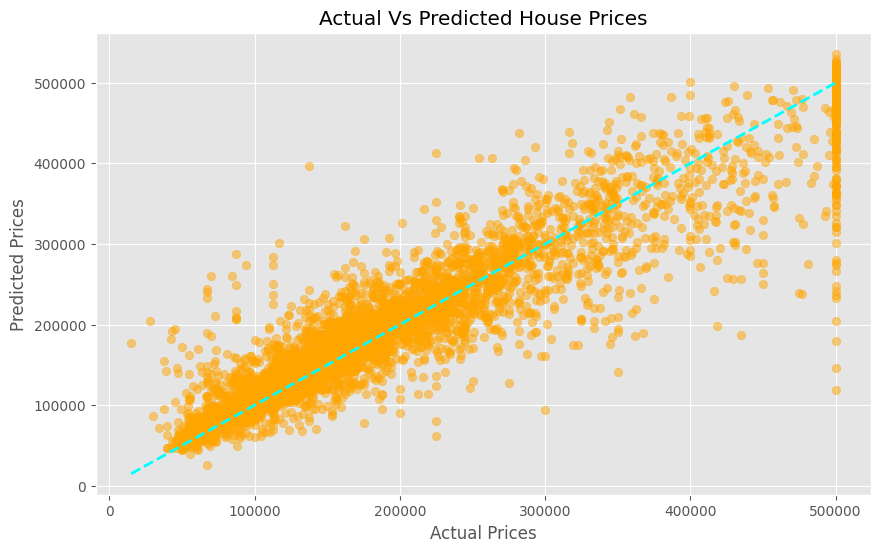

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(housing_test_labels, test_prediction, alpha=0.5,color="orange")
plt.plot([min(housing_test_labels), max(housing_test_labels)],
         [min(housing_test_labels), max(housing_test_labels)],
         color="cyan",linestyle="--", linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Vs Predicted House Prices')
plt.style.use("ggplot")
plt.show()